In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ranjithbeast","key":"8991bf37036225b2439e879824504010"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

100% 1.25G/1.25G [01:01<00:00, 20.6MB/s]
100% 1.25G/1.25G [01:01<00:00, 21.7MB/s]


In [ ]:
!mkdir dataset

In [ ]:
from zipfile import ZipFile
zf = ZipFile('plant-disease-recognition-dataset.zip', 'r')
zf.extractall('dataset')
zf.close()

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_path = '/content/dataset/Train/Train'
test_path = '/content/dataset/Test/Test'

In [ ]:
assert(train_path)
assert(test_path)

In [ ]:
batch_size = 16
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.optimizers import Adam
import keras
from keras.layers import Input

In [ ]:
num_classes=3
# Define the input tensor with the appropriate shape
input_tensor = Input(shape=target_size + (3,))

# Load the pretrained models
base_model_1 = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model_2 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model_3 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers of the base models
for layer in base_model_1.layers:
    layer.trainable = False

for layer in base_model_2.layers:
    layer.trainable = False

for layer in base_model_3.layers:
    layer.trainable = False

# Create the combined model
output_tensor_1 = base_model_1.output
output_tensor_1 = GlobalAveragePooling2D()(output_tensor_1)

output_tensor_2 = base_model_2.output
output_tensor_2 = GlobalAveragePooling2D()(output_tensor_2)

output_tensor_3 = base_model_3.output
output_tensor_3 = GlobalAveragePooling2D()(output_tensor_3)

concatenated_tensors = keras.layers.concatenate([output_tensor_1, output_tensor_2, output_tensor_3])
concatenated_tensors = Dense(256, activation='relu')(concatenated_tensors)
predictions = Dense(num_classes, activation='softmax')(concatenated_tensors)

model = Model(inputs=input_tensor, outputs=predictions)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps_per_epoch = test_generator.n // test_generator.batch_size

In [ ]:
epochs = 10
log = model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=epochs,
          validation_data=test_generator,
          validation_steps=test_steps_per_epoch)

Epoch 1/10
82/82 [==============================] - 243s 3s/step - loss: 0.5714 - accuracy: 0.8025 - val_loss: 0.3037 - val_accuracy: 0.9097
Epoch 2/10
82/82 [==============================] - 239s 3s/step - loss: 0.1822 - accuracy: 0.9395 - val_loss: 0.2900 - val_accuracy: 0.9375
Epoch 3/10
82/82 [==============================] - 239s 3s/step - loss: 0.1459 - accuracy: 0.9487 - val_loss: 0.2195 - val_accuracy: 0.9583
Epoch 4/10
82/82 [==============================] - 221s 3s/step - loss: 0.1222 - accuracy: 0.9602 - val_loss: 0.2479 - val_accuracy: 0.9375
Epoch 5/10
82/82 [==============================] - 221s 3s/step - loss: 0.0944 - accuracy: 0.9686 - val_loss: 0.2154 - val_accuracy: 0.9583
Epoch 6/10
82/82 [==============================] - 239s 3s/step - loss: 0.0927 - accuracy: 0.9724 - val_loss: 0.2802 - val_accuracy: 0.9306
Epoch 7/10
82/82 [==============================] - 240s 3s/step - loss: 0.1030 - accuracy: 0.9655 - val_loss: 0.2037 - val_accuracy: 0.9514
Epoch 8/10
82

In [ ]:
_, accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test accuracy:", accuracy)

9/9 [==============================] - 20s 2s/step - loss: 0.2640 - accuracy: 0.9514
Test accuracy: 0.9513888955116272


In [ ]:
import matplotlib.pyplot as plt
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

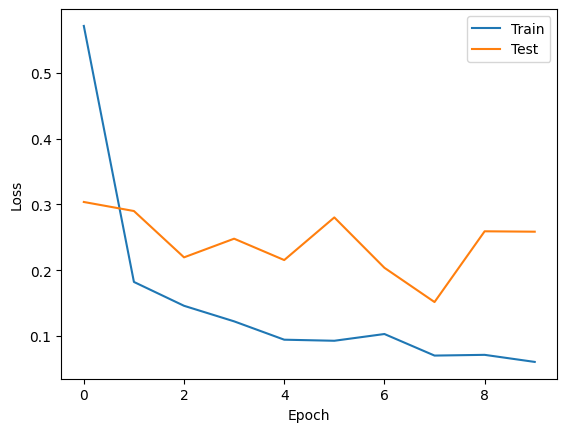

In [ ]:
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

10/10 [==============================] - 26s 2s/step


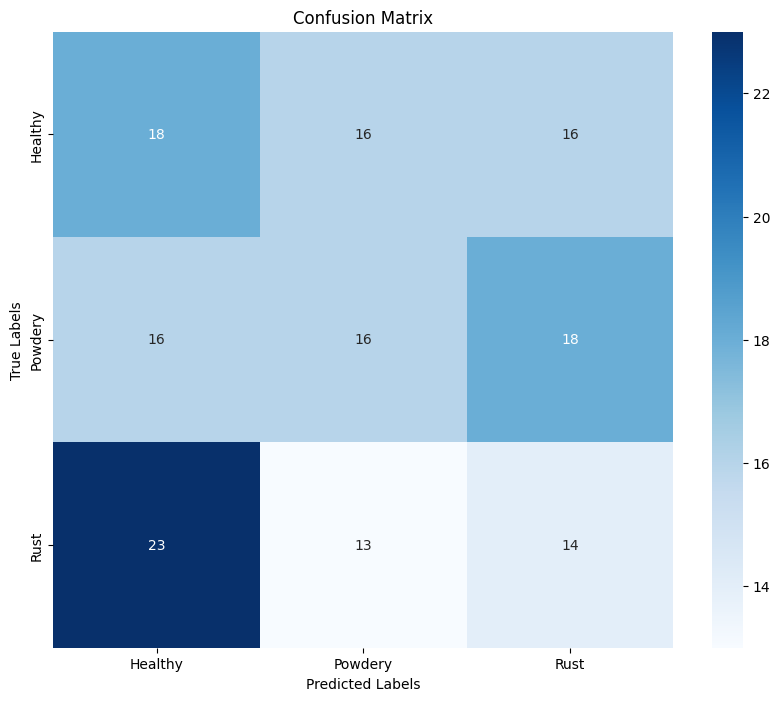

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Evaluate the model on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
eval_path="/content/dataset/Validation/Validation"
eval_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
    eval_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 60 images belonging to 3 classes.


In [ ]:
_, accuracy = model.evaluate(eval_generator, steps=test_steps_per_epoch)
print("Test accuracy:", accuracy)

4/9 [============>.................] - ETA: 11s - loss: 0.0071 - accuracy: 1.0000

9/9 [==============================] - 10s 863ms/step - loss: 0.0071 - accuracy: 1.0000
Test accuracy: 1.0
